In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.initializers import RandomUniform
from keras.layers import (
    LSTM,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    Input,
    MaxPooling1D,
    TimeDistributed,
    concatenate,
)
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import Progbar

from prepro import (
    add_char_information,
    create_batches,
    create_matrices,
    iterate_minibatches,
    padding,
    readfile,
    tag_dataset,
)
from validation import compute_f1

Using TensorFlow backend.


# Prepare Data

### Download data

In [3]:
# %cd embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip
# %cd ..

### Load data

In [4]:
train_sentences = readfile("../data/train.txt")
val_sentences = readfile("../data/valid.txt")
test_sentences = readfile("../data/test.txt")
print(len(train_sentences), len(val_sentences), len(test_sentences))

14041 3250 3453


In [5]:
train_sentences[0]

[['EU', 'B-ORG\n'],
 ['rejects', 'O\n'],
 ['German', 'B-MISC\n'],
 ['call', 'O\n'],
 ['to', 'O\n'],
 ['boycott', 'O\n'],
 ['British', 'B-MISC\n'],
 ['lamb', 'O\n'],
 ['.', 'O\n']]

### Add character information

In [6]:
train_sentences = add_char_information(train_sentences)
val_sentences = add_char_information(val_sentences)
test_sentences = add_char_information(test_sentences)
all_sentences = train_sentences + val_sentences + test_sentences

In [7]:
train_sentences[0]

[['EU', ['E', 'U'], 'B-ORG\n'],
 ['rejects', ['r', 'e', 'j', 'e', 'c', 't', 's'], 'O\n'],
 ['German', ['G', 'e', 'r', 'm', 'a', 'n'], 'B-MISC\n'],
 ['call', ['c', 'a', 'l', 'l'], 'O\n'],
 ['to', ['t', 'o'], 'O\n'],
 ['boycott', ['b', 'o', 'y', 'c', 'o', 't', 't'], 'O\n'],
 ['British', ['B', 'r', 'i', 't', 'i', 's', 'h'], 'B-MISC\n'],
 ['lamb', ['l', 'a', 'm', 'b'], 'O\n'],
 ['.', ['.'], 'O\n']]

### Visualize

#### Sentence length

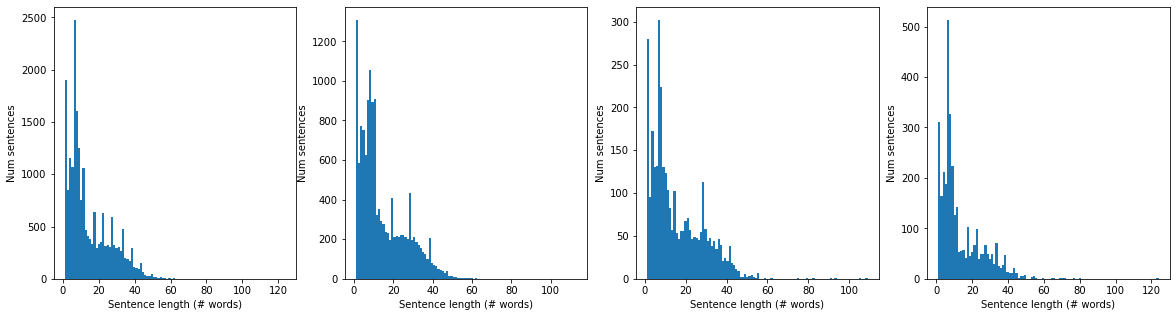

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for ax, sentences_set in zip(
    axs, [all_sentences, train_sentences, val_sentences, test_sentences]
):
    sentences_lens = [len(sentence) for sentence in sentences_set]
    ax.hist(sentences_lens, bins=100)
    ax.set_ylabel("Num sentences")
    ax.set_xlabel("Sentence length (# words)");

In [9]:
max_sentence_len = max(sentences_lens)
print(max_sentence_len)

124


#### Word length

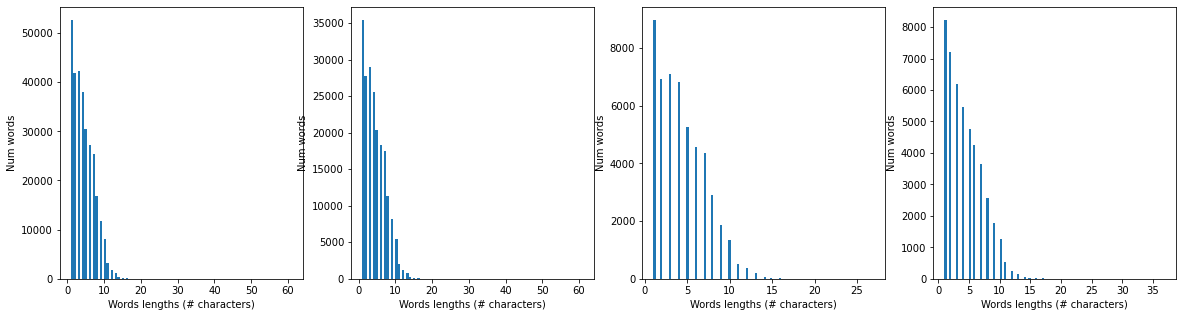

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for ax, sentences_set in zip(
    axs, [all_sentences, train_sentences, val_sentences, test_sentences]
):
    word_lens = [
        len(word[0]) for sentence in sentences_set for word in sentence
    ]
    ax.hist(word_lens, bins=100)
    ax.set_ylabel("Num words")
    ax.set_xlabel("Words lengths (# characters)");

In [11]:
max_word_len = max(word_lens)
print(max_word_len)

37


### Prepare mappings and embeddings

#### Get classes and word corpus

In [12]:
classes = set()
words = {}

for sentence in all_sentences:
    for word, char, label in sentence:
        classes.add(label)
        words[word.lower()] = True

In [13]:
print(len(classes), len(words))

9 26869


#### Classes mapping

In [14]:
# Create a mapping for the classes
class2idx = {"PADDING_CLASS": 0}
for label in classes:
    class2idx[label] = len(class2idx)
print(len(class2idx))
print(class2idx)

10
{'PADDING_CLASS': 0, 'B-LOC\n': 1, 'O\n': 2, 'B-ORG\n': 3, 'I-LOC\n': 4, 'B-MISC\n': 5, 'I-ORG\n': 6, 'I-MISC\n': 7, 'B-PER\n': 8, 'I-PER\n': 9}


In [15]:
# Create reverse mapping for classes and store it
idx2class = {v: k for k, v in class2idx.items()}
np.save("models/idx2Label.npy", idx2class)
print(idx2class)

{0: 'PADDING_CLASS', 1: 'B-LOC\n', 2: 'O\n', 3: 'B-ORG\n', 4: 'I-LOC\n', 5: 'B-MISC\n', 6: 'I-ORG\n', 7: 'I-MISC\n', 8: 'B-PER\n', 9: 'I-PER\n'}


#### Cases mapping and embedding

In [16]:
# Create a look-up table for the cases
case2idx = {
    "PADDING_WORD": 0,
    "numeric": 1,
    "allLower": 2,
    "allUpper": 3,
    "initialUpper": 4,
    "other": 5,
    "mainly_numeric": 6,
    "contains_digit": 7,
}
case_embeddings = np.identity(len(case2idx), dtype="float32")
print(len(case2idx), case_embeddings.shape)
print(case2idx)
print(case_embeddings)

8 (8, 8)
{'PADDING_WORD': 0, 'numeric': 1, 'allLower': 2, 'allUpper': 3, 'initialUpper': 4, 'other': 5, 'mainly_numeric': 6, 'contains_digit': 7}
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


#### Word mapping and embeddings

In [17]:
embeddings_size = 50
vocabulary_embeddings = open(
    f"../embeddings/glove.6B.{embeddings_size}d.txt", encoding="utf-8"
)

In [18]:
# Get word embedding
word2idx = {}
word_embeddings = []

# Zero verctor for padding words
word2idx["PADDING_WORD"] = len(word2idx)
vector = np.zeros(embeddings_size)  # Zero vector vor 'PADDING' word
word_embeddings.append(vector)

# Random vector for uknown words
word2idx["UNKNOWN_WORD"] = len(word2idx)
vector = np.random.uniform(-0.25, 0.25, embeddings_size)
word_embeddings.append(vector)

for line in vocabulary_embeddings:
    split = line.strip().split(" ")
    word = split[0]
    embedding = split[1:]

    if word.lower() in words:
        vector = np.array([float(num) for num in embedding])
        word_embeddings.append(vector)
        word2idx[word] = len(word2idx)

word_embeddings = np.array(word_embeddings)

print(len(word2idx), word_embeddings.shape)

22949 (22949, 50)


In [19]:
# Store word embedding indices
np.save("models/word2idx.npy", word2idx)

#### Character mapping and embedding

In [20]:
chars = set()
for sentence in all_sentences:
    for word in sentence:
        for char in word[0]:
            chars.add(char)

In [21]:
print(len(chars))
all_chars = " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|"
print(len(all_chars))

85
93


In [22]:
# Character embedding
char2idx = {"PADDING_CHAR": 0, "UNKNOWN_CHAR": 1}
for c in all_chars:
    char2idx[c] = len(char2idx)
print(len(char2idx))

95


### Train, val test data splits

In [23]:
print(max_sentence_len, max_word_len)

124 37


In [24]:
train_set = padding(
    create_matrices(train_sentences, word2idx, class2idx, case2idx, char2idx),
    max_sentence_len,
    max_word_len,
    word2idx,
    case2idx,
    char2idx,
    class2idx,
)
val_set = padding(
    create_matrices(val_sentences, word2idx, class2idx, case2idx, char2idx),
    max_sentence_len,
    max_word_len,
    word2idx,
    case2idx,
    char2idx,
    class2idx,
)
test_set = padding(
    create_matrices(test_sentences, word2idx, class2idx, case2idx, char2idx),
    max_sentence_len,
    max_word_len,
    word2idx,
    case2idx,
    char2idx,
    class2idx,
)
print(f"num train sentences: {len(train_set)}")
print(f"num val sentences: {len(val_set)}")
print(f"num test sentences: {len(test_set)}")

num train sentences: 14041
num val sentences: 3250
num test sentences: 3453


In [25]:
train_set[0]  # [words_idxs, word_case_idxs, word_char_idx, word_class_idx]

[array([ 641, 6732,  512,  578,    6, 4940,  295, 8353,    4,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0], dtype=int32),
 array([3, 2, 4, 2, 2, 2, 4, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [26]:
sentence_idx = 1000
print(f"Raw data of train sentence {sentence_idx}:")
print(f"{train_sentences[sentence_idx]}")
print(f"Sentence has {len(train_sentences[sentence_idx])} words")
print(
    "word embedding idxs:",
    len(train_set[sentence_idx][0]),
    train_set[sentence_idx][0],
)
print(
    "word case embedding idxs:",
    len(train_set[sentence_idx][1]),
    train_set[sentence_idx][1],
)
print("word char embedding idxs:", train_set[sentence_idx][2].shape)
print(
    "word class embedding idxs:",
    len(train_set[sentence_idx][3]),
    train_set[sentence_idx][3],
)

Raw data of train sentence 1000:
[['Australian', ['A', 'u', 's', 't', 'r', 'a', 'l', 'i', 'a', 'n'], 'B-MISC\n'], ['coach', ['c', 'o', 'a', 'c', 'h'], 'O\n'], ['Geoff', ['G', 'e', 'o', 'f', 'f'], 'B-PER\n'], ['Marsh', ['M', 'a', 'r', 's', 'h'], 'I-PER\n'], ['said', ['s', 'a', 'i', 'd'], 'O\n'], ['he', ['h', 'e'], 'O\n'], ['was', ['w', 'a', 's'], 'O\n'], ['impressed', ['i', 'm', 'p', 'r', 'e', 's', 's', 'e', 'd'], 'O\n'], ['with', ['w', 'i', 't', 'h'], 'O\n'], ['the', ['t', 'h', 'e'], 'O\n'], ['competitiveness', ['c', 'o', 'm', 'p', 'e', 't', 'i', 't', 'i', 'v', 'e', 'n', 'e', 's', 's'], 'O\n'], ['of', ['o', 'f'], 'O\n'], ['the', ['t', 'h', 'e'], 'O\n'], ['opposition', ['o', 'p', 'p', 'o', 's', 'i', 't', 'i', 'o', 'n'], 'O\n'], ['.', ['.'], 'O\n']]
Sentence has 15 words
word embedding idxs: 124 [ 797  609 9081 7949   18   20   17 5589   19    2 8185    5    2  575
    4    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   

### Create training arrays

In [27]:
def plot_classes_counts(classes_array, class_weight=None):
    classes, counts = np.unique(classes_array, return_counts = True)
    total = np.sum(counts)
    num_classes = len(classes)
    classes_counts = {class_: count for class_, count in zip(classes, counts)}
    plt.bar(classes, counts)
    print(classes_counts)
    if class_weight is None:
        class_weight = {class_: (1 / count) * (total / num_classes) for class_, count in zip(classes, counts)}
    classes_weights = np.vectorize(class_weight.get)(classes_array)
    print(class_weight)
    return np.squeeze(classes_weights), class_weight # shape for keras when sampel_weight_complie = 'temporal' must be 2D see below when model.compile() call

(14041, 124)
(14041, 124)
(14041, 124, 37)
(14041, 124, 1)
{0: 1537463, 1: 7140, 2: 169578, 3: 6321, 4: 1157, 5: 3438, 6: 3704, 7: 1155, 8: 6600, 9: 4528}
{0: 0.11324396099288243, 1: 24.384929971988793, 2: 1.0267157296347402, 3: 27.544439171017242, 4: 150.48262748487468, 5: 50.642350203606746, 6: 47.00550755939525, 7: 150.74320346320346, 8: 26.380060606060606, 9: 38.45150176678445}
{'PADDING_CLASS': 0, 'B-LOC\n': 1, 'O\n': 2, 'B-ORG\n': 3, 'I-LOC\n': 4, 'B-MISC\n': 5, 'I-ORG\n': 6, 'I-MISC\n': 7, 'B-PER\n': 8, 'I-PER\n': 9}


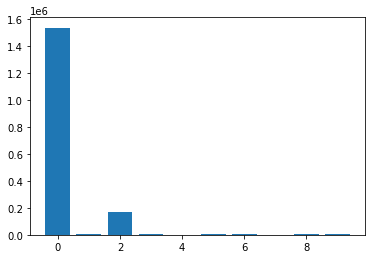

In [28]:
train_words = np.asarray([sentence[0] for sentence in train_set])
train_casing = np.asarray([sentence[1] for sentence in train_set])
train_chars = np.asarray([sentence[2] for sentence in train_set])
train_classes = np.expand_dims(np.asarray([sentence[3] for sentence in train_set]), -1)
print(train_words.shape)
print(train_casing.shape)
print(train_chars.shape)
print(train_classes.shape)
train_sample_weights, class_weight = plot_classes_counts(train_classes)
print(class2idx)

> **NOTE**: The dataset is already unbalance due to the class O ("other")
Padding makes the dataset be even more unbalance.
We compute sample_weights to balance the loss so that PADDING and OTHER classes get less weight while training. 

> **NOTE**: At evaluation time we also pass the val_sample_weight and test_sample_weight, however, note that the weights must be the ones of the training, so that the losses are comparables. 

> **NOTE**: An alternatieve is using the [padding and masking](https://www.tensorflow.org/guide/keras/masking_and_padding) options ot tensorflow/keras to tell the lstm layers to ignore certain time steps

(3250, 124)
(3250, 124)
(3250, 124, 37)
(3250, 124, 1)
{0: 351638, 1: 1837, 2: 42759, 3: 1341, 4: 257, 5: 922, 6: 751, 7: 346, 8: 1842, 9: 1307}
{0: 0.11460649872880634, 1: 21.937942297223735, 2: 0.9424916391870717, 3: 30.052199850857566, 4: 156.80933852140078, 5: 43.70932754880694, 6: 53.66178428761651, 7: 116.47398843930635, 8: 21.878393051031487, 9: 30.83397092578424}


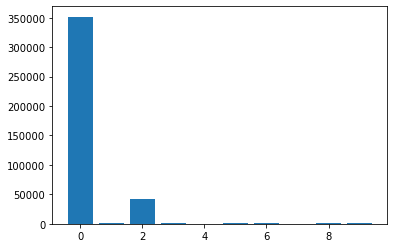

In [29]:
val_words = np.asarray([sentence[0] for sentence in val_set])
val_casing = np.asarray([sentence[1] for sentence in val_set])
val_chars = np.asarray([sentence[2] for sentence in val_set])
val_classes = np.expand_dims(np.asarray([sentence[3] for sentence in val_set]), -1)
print(val_words.shape)
print(val_casing.shape)
print(val_chars.shape)
print(val_classes.shape)
val_sample_weights, class_weight = plot_classes_counts(val_classes)

(3453, 124)
(3453, 124)
(3453, 124, 37)
(3453, 124, 1)
{0: 381737, 1: 1668, 2: 38323, 3: 1661, 4: 257, 5: 702, 6: 835, 7: 216, 8: 1617, 9: 1156}
{0: 0.11216413394562225, 1: 25.669784172661867, 2: 1.1172716123476762, 3: 25.77796508127634, 4: 166.60389105058366, 5: 60.99316239316239, 6: 51.27808383233533, 7: 198.22777777777776, 8: 26.479406307977737, 9: 37.03910034602076}


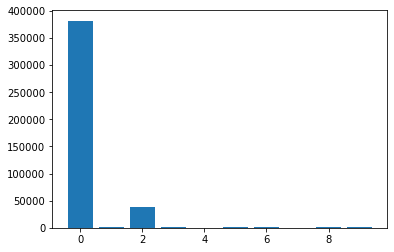

In [30]:
test_words = np.asarray([sentence[0] for sentence in test_set])
test_casing = np.asarray([sentence[1] for sentence in test_set])
test_chars = np.asarray([sentence[2] for sentence in test_set])
test_classes = np.expand_dims(np.asarray([sentence[3] for sentence in test_set]), -1)
print(test_words.shape)
print(test_casing.shape)
print(test_chars.shape)
print(test_classes.shape)
test_sample_weights, class_weight = plot_classes_counts(test_classes)

### Define model

In [31]:
# Word features come from glove.6B embeddings
words_input = Input(
    shape=(None,), dtype="int32", name="words_input"
)  # None indicates a variables input (sentence length is variable)
words = Embedding(
    input_dim=word_embeddings.shape[0],
    output_dim=word_embeddings.shape[1],
    weights=[word_embeddings],
    trainable=False,
)(words_input)

# Casing features
casing_input = Input(
    shape=(None,), dtype="int32", name="casing_input"
)  # None indicates a variables input (sentence length is variable)
casing = Embedding(
    input_dim=case_embeddings.shape[0],
    output_dim=case_embeddings.shape[1],
    weights=[case_embeddings],
    trainable=False,
)(casing_input)

# Character features learned with a 1D CNN
character_input = Input(
    shape=(
        None,
        max_word_len,
    ),
    name="char_input",
)
embed_char_out = TimeDistributed(
    Embedding(
        input_dim=len(char2idx),
        output_dim=30,
        embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5),
    ),
    name="char_embedding",
)(character_input)
dropout = Dropout(0.5)(embed_char_out)
conv1d_out = TimeDistributed(
    Conv1D(
        kernel_size=3, filters=30, padding="same", activation="tanh", strides=1
    )
)(dropout)
maxpool_out = TimeDistributed(MaxPooling1D(max_word_len))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)

# Concatenate features
output = concatenate([words, casing, char])

# Bidirectional LSTM
output = Bidirectional(
    LSTM(200, return_sequences=True, dropout=0.50, recurrent_dropout=0.25)
)(output)

# Same fully connected for each word in the sequence
output = TimeDistributed(Dense(len(class2idx), activation="softmax"))(output)

# Define model input and output
model = Model(
    inputs=[words_input, casing_input, character_input], outputs=[output]
)
# Uncomment to train with sample weights
# model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=['accuracy'], sample_weight_mode='temporal')
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, None, 37)     0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, None, 37, 30) 2850        char_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 37, 30) 0           char_embedding[0][0]             
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 37, 30) 2730        dropout_1[0][0]                  
____________________________________________________________________________________________

### Training loop

In [32]:
# epochs = 5
# for epoch in range(epochs):
#     print("Epoch %d/%d" % (epoch, epochs))
#     a = Progbar(len(train_num_sentences_in_batch))
#     for i, batch in enumerate(
#         iterate_minibatches(train_batches, train_num_sentences_in_batch)
#     ):
#         labels, words, casing, char = batch
#         model.train_on_batch([words, casing, char], labels)
#         a.update(i)
#     a.update(i + 1)
#     print(" ")

In [33]:
MODEL_CHECKPOINT_FILE = 'models/model.h5'
checkpointer = ModelCheckpoint(filepath=MODEL_CHECKPOINT_FILE,
                               monitor='val_loss',
                               save_best_only=True,
                               verbose=1)

In [34]:
filename='models/history.csv'
history_logger=CSVLogger(filename, separator=",", append=False)

In [35]:
num_training_samples = 1000
num_val_samples = 100
history = model.fit(
    [train_words[:num_training_samples], train_casing[:num_training_samples], train_chars[:num_training_samples]],
    train_classes[:num_training_samples],
#     sample_weight = np.squeeze(train_sample_weights), # Uncomment to train with sample weights
    batch_size=32, 
    epochs=10, 
    shuffle=True,
    callbacks=[checkpointer, history_logger],
    validation_data=([val_words[:num_val_samples], val_casing[:num_val_samples], val_chars[:num_val_samples]], val_classes[:num_val_samples]), 
    verbose=1)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1000 samples, validate on 100 samples
Epoch 1/10
1000/1000 [==============================] - 36s 36ms/step - loss: 0.2268 - accuracy: 0.9312 - val_loss: 0.0968 - val_accuracy: 0.9777

Epoch 00001: val_loss improved from inf to 0.09680, saving model to models/model.h5
Epoch 2/10
1000/1000 [==============================] - 31s 31ms/step - loss: 0.0772 - accuracy: 0.9780 - val_loss: 0.0620 - val_accuracy: 0.9835

Epoch 00002: val_loss improved from 0.09680 to 0.06203, saving model to models/model.h5
Epoch 3/10
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0562 - accuracy: 0.9836 - val_loss: 0.0460 - val_accuracy: 0.9897

Epoch 00003: val_loss improved from 0.06203 to 0.04602, saving model to models/model.h5
Epoch 4/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.0460 - accuracy: 0.9866 - val_loss: 0.0431 - val_accuracy: 0.9902

Epoch 00004: val_loss improved from 0.04602 to 0.04315, saving model to models/model.h5
Epoch 5/10
1000/1

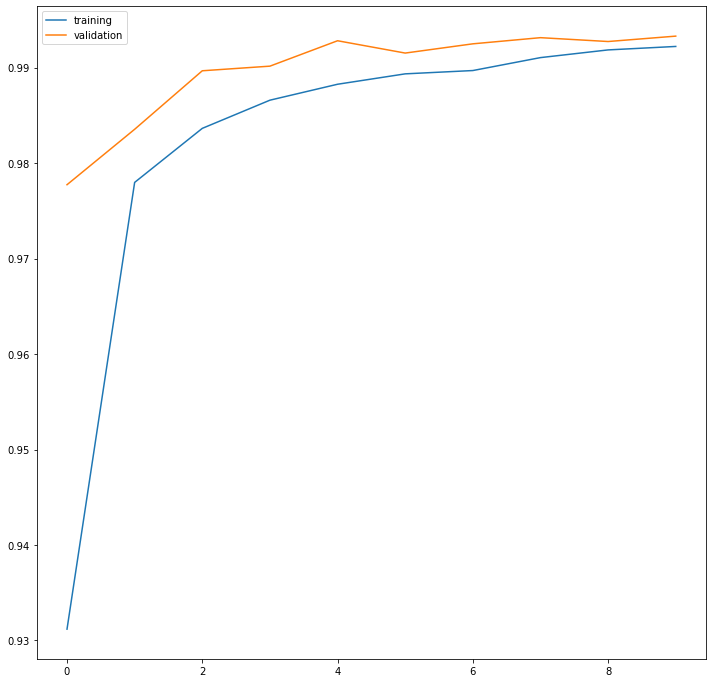

In [36]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"], label='training')
plt.plot(hist["val_accuracy"], label='validation')
plt.legend()
plt.show()

### Evaluate

In [37]:
model.load_weights(MODEL_CHECKPOINT_FILE)

In [38]:
results = model.evaluate(
    [val_words, val_casing, val_chars],
    val_classes,
    batch_size=128,
#     sample_weight=val_sample_weights
)
print(results)

3250/3250 [==============================] - 13s 4ms/step
[0.025783293736668732, 0.9924168586730957]


In [39]:
results = model.evaluate(
    [test_words, test_casing, test_chars],
    test_classes,
    batch_size=128,
#     sample_weight=test_sample_weights
)
print(results)

3453/3453 [==============================] - 13s 4ms/step
[0.022602540194608493, 0.9928230047225952]


### Predictions

In [40]:
val_predictions = model.predict(
    [val_words, val_casing, val_chars], 
    batch_size=128
)
print(val_predictions.shape)

(3250, 124, 10)


In [41]:
test_predictions = model.predict(
    [test_words, test_casing, test_chars], 
    batch_size=128
)
print(test_predictions.shape)

(3453, 124, 10)


### Compute performance metrics without considering the padding tokers

> **NOTE**: By ignoring the padding some metrics metrics are ill-defined becuase some prediction might still return that PADDING is the best class, while padding is not in the valid groundtruth classes

In [42]:
def extract_valid_classes_and_predictions(classes, predictions, ignore_padding=False):
    # NOTE: the valid_predictions can still contain predictions that are 0 = PADDING
    # However this is not going to be in the valid classes. 
    valid_classes = []
    valid_predictions = []
    for sentence_predictions, sentence_classes in zip(predictions, classes):
        for word_prediction, word_class in zip(sentence_predictions, sentence_classes):
            if ignore_padding:
                if word_class[0] != 0:
                    valid_classes.append(word_class)
                    valid_predictions.append(word_prediction)
            else:
                valid_classes.append(word_class)
                valid_predictions.append(word_prediction)    
    valid_clases = np.squeeze(np.asarray(valid_classes))
    valid_predictions = np.asarray(valid_predictions)
    valid_predicted_classes = np.argmax(valid_predictions, axis=1)
    return valid_clases, valid_predictions, valid_predicted_classes

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
metrics = [accuracy_score, precision_score, recall_score, f1_score]

In [44]:
valid_classes, valid_predictions, valid_predicted_classes = extract_valid_classes_and_predictions(val_classes, val_predictions, ignore_padding=False)  
for metric in metrics:
    if metric != accuracy_score:
        out = metric(valid_classes, valid_predicted_classes, average='macro')
    else:
        out = metric(valid_classes, valid_predicted_classes)
    print(metric.__name__, out)
unique, count = np.unique(valid_predicted_classes, return_counts=True)
print(unique, count)
unique, count = np.unique(valid_classes, return_counts=True)
print(unique, count)

accuracy_score 0.9924168734491315
precision_score 0.8568763297101543
recall_score 0.6405188211114077
f1_score 0.7108169421887152
[0 1 2 3 4 5 6 7 8 9] [351658   1504  44817    994     79    649    318    141   1617   1223]
[0 1 2 3 4 5 6 7 8 9] [351638   1837  42759   1341    257    922    751    346   1842   1307]


In [45]:
valid_classes, valid_predictions, valid_predicted_classes = extract_valid_classes_and_predictions(val_classes, val_predictions, ignore_padding=True)  
for metric in metrics:
    if metric != accuracy_score:
        out = metric(valid_classes, valid_predicted_classes, average='macro')
    else:
        out = metric(valid_classes, valid_predicted_classes)
    print(metric.__name__, out)
unique, count = np.unique(valid_predicted_classes, return_counts=True)
print(unique, count)
unique, count = np.unique(valid_classes, return_counts=True)
print(unique, count)

accuracy_score 0.940500759316226
precision_score 0.7568820170541077
recall_score 0.5405188211114076
f1_score 0.610819785941559
[0 1 2 3 4 5 6 7 8 9] [   20  1504 44817   994    79   649   318   141  1617  1223]
[1 2 3 4 5 6 7 8 9] [ 1837 42759  1341   257   922   751   346  1842  1307]


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
a = [1,2,3,4,5]

In [2]:
a[:100]

[1, 2, 3, 4, 5]

In [4]:
import numpy as np
a = np.asarray([1,2,3,4,5])

In [5]:
a[:100]

array([1, 2, 3, 4, 5])